### <span style='color:#ff5f27'> 📝 Imports

In [23]:
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from functions import util
import json
import numpy as np

import warnings
warnings.filterwarnings("ignore")

#### Connect to Hopsworks Feature Store </span>

In [24]:
with open('../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
fs = project.get_feature_store() 

2025-01-07 18:42:27,703 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-07 18:42:27,717 INFO: Initializing external client
2025-01-07 18:42:27,717 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-07 18:42:29,547 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207502


In [25]:
# Retrieve feature groups
accidents_fg = fs.get_feature_group(
    name='accidents',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

In [26]:
# Select features for training data.
selected_features = accidents_fg.select(['accidents']).join(weather_fg.select_all(), on=['date', 'city'])
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.03s) 


,accidents,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,day_of_week
0,14.0,2024-08-15 00:00:00+00:00,19.479584,0.100000,18.359999,175.431091,Stockholm,3.0
1,17.0,2024-09-20 00:00:00+00:00,14.717083,0.000000,12.641076,263.211121,Stockholm,4.0
2,14.0,2024-09-27 00:00:00+00:00,11.081664,18.000002,14.410121,329.206238,Stockholm,4.0
3,6.0,2024-10-05 00:00:00+00:00,8.946250,0.000000,13.608762,240.701645,Stockholm,5.0
4,23.0,2024-10-24 00:00:00+00:00,10.964999,0.000000,20.880001,261.377655,Stockholm,3.0
5,6.0,2024-10-27 00:00:00+00:00,9.733748,6.200000,23.400002,206.131454,Stockholm,6.0
6,22.0,2024-10-31 00:00:00+00:00,7.887916,1.400000,18.116623,244.267090,Stockholm,3.0
7,18.0,2024-11-04 00:00:00+00:00,4.056667,0.000000,16.928614,279.599670,Stockholm,0.0
8,9.0,2024-11-10 00:00:00+00:00,5.473333,0.100000,9.292255,145.380463,Stockholm,6.0
9,4.0,2024-11-30 00:00:00+00:00,4.529583,1.400000,21.677860,229.169464,Stockholm,5.0


In [27]:
feature_view = fs.get_or_create_feature_view(
    name='accidents_fv',
    description="weather features with accidents as the target",
    version=1,
    labels=['accidents'],
    query=selected_features,
)

#### Split the training data into train/test data sets </span>

In [28]:
start_date_test_data = "2024-12-01"

# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [29]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.94s) 


ValueError: NaTType does not support timestamp

In [68]:
X_train.sort_values(by='date', inplace=True)
X_train

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,day_of_week
22,2024-08-01 00:00:00+00:00,17.496252,0.0,14.764390,316.718292,Stockholm,3
113,2024-08-02 00:00:00+00:00,17.025417,0.0,11.885453,317.973785,Stockholm,4
114,2024-08-03 00:00:00+00:00,17.908751,0.5,10.009036,319.460907,Stockholm,5
9,2024-08-04 00:00:00+00:00,17.523336,8.5,7.208994,115.214478,Stockholm,6
87,2024-08-05 00:00:00+00:00,18.685835,0.4,8.654986,34.007500,Stockholm,0
...,...,...,...,...,...,...,...
17,2024-11-26 00:00:00+00:00,5.871250,0.5,19.091883,217.565536,Stockholm,1
85,2024-11-27 00:00:00+00:00,4.477500,0.1,15.038350,264.764740,Stockholm,2
77,2024-11-28 00:00:00+00:00,1.327500,0.0,13.350371,351.283630,Stockholm,3
90,2024-11-29 00:00:00+00:00,0.075417,0.1,17.474840,249.539124,Stockholm,4


In [69]:
X_test.sort_values(by='date', inplace=True)
X_test

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,day_of_week
42,2024-12-01 00:00:00+00:00,6.315000,0.000000,19.639805,222.447037,Stockholm,6
91,2024-12-02 00:00:00+00:00,4.615000,3.400000,20.052032,213.260422,Stockholm,0
155,2024-12-03 00:00:00+00:00,-0.864167,6.200000,21.744267,3.090119,Stockholm,1
58,2024-12-04 00:00:00+00:00,-3.689167,0.000000,8.604301,39.083725,Stockholm,2
147,2024-12-05 00:00:00+00:00,-0.330833,0.400000,10.801499,118.384117,Stockholm,3
92,2024-12-06 00:00:00+00:00,1.925417,0.100000,16.125830,148.958862,Stockholm,4
6,2024-12-07 00:00:00+00:00,1.225417,0.000000,12.722830,120.137360,Stockholm,5
19,2024-12-08 00:00:00+00:00,0.719167,0.000000,10.587917,19.437220,Stockholm,6
103,2024-12-09 00:00:00+00:00,-0.255833,0.000000,13.504799,344.264038,Stockholm,0
27,2024-12-10 00:00:00+00:00,-2.337083,0.000000,16.946787,274.812103,Stockholm,1


In [70]:
# Drop the index columns - 'date' (event_time) and 'city' (primary key)
train_features = X_train.drop(['date', 'city'], axis=1)
test_features = X_test.drop(['date', 'city'], axis=1)

In [71]:
y_train

,accidents
0,17.0
1,9.0
2,7.0
3,9.0
4,10.0
...,...
150,9.0
151,20.0
152,6.0
153,15.0


#### Modeling

In [72]:
# Creating an instance of the XGBoost Regressor with enable_categorical set to True
xgb_regressor = XGBRegressor(enable_categorical=True)

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(train_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [73]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 71.11246
R squared: 0.06954676210372435


In [74]:
df = y_test
df['predicted_accidents'] = np.round(y_pred).astype(np.int64) #  0.49 -> 0 and 0.5 -> 1

In [75]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(50)

,accidents,predicted_accidents,date
42,5.0,19,2024-12-01 00:00:00+00:00
91,9.0,17,2024-12-02 00:00:00+00:00
155,27.0,19,2024-12-03 00:00:00+00:00
58,22.0,14,2024-12-04 00:00:00+00:00
147,17.0,17,2024-12-05 00:00:00+00:00
92,18.0,16,2024-12-06 00:00:00+00:00
6,14.0,15,2024-12-07 00:00:00+00:00
19,6.0,16,2024-12-08 00:00:00+00:00
103,25.0,17,2024-12-09 00:00:00+00:00
27,22.0,16,2024-12-10 00:00:00+00:00


In [76]:
dates_only = pd.to_datetime(df['date']).dt.date
dates_only

42     2024-12-01
91     2024-12-02
155    2024-12-03
58     2024-12-04
147    2024-12-05
92     2024-12-06
6      2024-12-07
19     2024-12-08
103    2024-12-09
27     2024-12-10
7      2024-12-11
28     2024-12-12
67     2024-12-13
112    2024-12-14
43     2024-12-15
125    2024-12-16
139    2024-12-17
44     2024-12-18
8      2024-12-19
86     2024-12-20
78     2024-12-21
20     2024-12-22
21     2024-12-23
93     2024-12-24
104    2024-12-25
45     2024-12-26
59     2024-12-27
105    2024-12-28
106    2024-12-29
140    2024-12-30
156    2024-12-31
29     2025-01-01
46     2025-01-02
30     2025-01-03
68     2025-01-04
Name: date, dtype: object

In [21]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "accidents_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [22]:
file_path = images_dir + "/accidents_hindcast.png"
plt = util.traf_plot_accidents_forecast("stockholm", df[:10], file_path, hindcast=True)
plt.show()

NameError: name 'df' is not defined

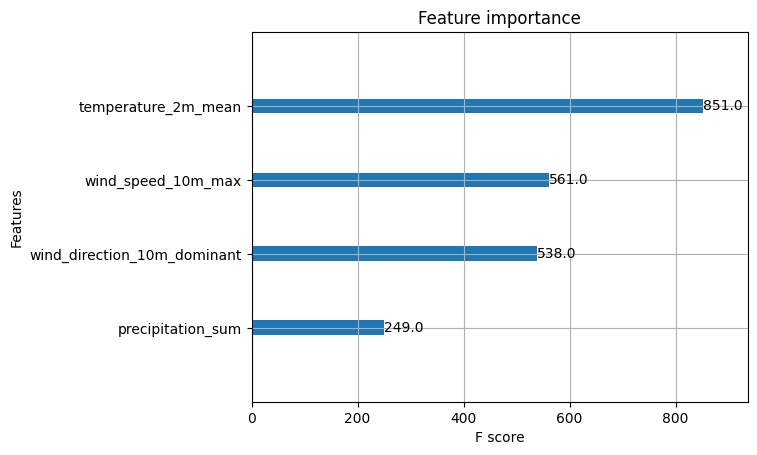

In [79]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=4)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

#### Model Registry


In [80]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [81]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [82]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [83]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="accident_model", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="No of accidents predicted using weather data",
)

aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/289115 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/43914 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18460 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/125 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/722 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1207502/models/accident_model/1


Model(name: 'accident_model', version: 1)